In [215]:
from sklearn.model_selection import cross_validate 

# Python Experience Level: Logistique Regression, LDA, KNN, SVM

In [216]:
import pandas as pd
import numpy as np
import copy
import random
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn.metrics import log_loss

### Fonction utiles et recuperation des données 

Ici changer chemin accès DATADIR_UCI et SIGNALS 

In [217]:
## LIBRARIES
import seaborn as sns

from sklearn.model_selection import train_test_split


randomseed = 1234

## DATA LOADING AND PREPROCESSING
# Load the data
gym = pd.read_csv('../../gym_members_exercise_tracking.csv')

# set 'Gender', 'Workout_Type', 'Workout_Frequency (days/week)' and 'Experience_Level' as categorical
for col in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    gym[col] = gym[col].astype('category')

# log transform Weight and BMI
gym['Weight (kg)'] = np.log1p(gym['Weight (kg)'])

# transform 'Fat_Percentage'
max_fat = gym['Fat_Percentage'].max()
gym['Fat_Percentage'] = gym['Fat_Percentage'].apply(lambda x: np.sqrt(max_fat+1)-x)

# rename transformed columns
gym.rename(columns={'Weight (kg)': 'LWeight', 'Fat_Percentage': 'SFat_Percentage'}, inplace=True)

gym.drop(columns=['BMI'], inplace=True)

# divide into train and test set
gym_train, gym_test = train_test_split(gym, test_size=0.2, random_state=randomseed)

# Create gym_train_scale, gym_test_scale
gym_train_scale = gym_train.copy()
gym_test_scale = gym_test.copy()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.fit_transform(gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])

gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.transform(gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])


# Create X_train_exp_level, X_test_exp_level, y_train_exp_level, y_test_exp_level
X_train_exp_level = gym_train.drop(columns=['Experience_Level'])
X_train_exp_level_scale = gym_train_scale.drop(columns=['Experience_Level'])
y_train_exp_level = gym_train['Experience_Level']
X_test_exp_level = gym_test.drop(columns=['Experience_Level'])
X_test_exp_level_scale = gym_test_scale.drop(columns=['Experience_Level'])
y_test_exp_level = gym_test['Experience_Level']

# Create X_train_calories, X_test_calories, y_train_calories, y_test_calories
X_train_calories = gym_train.drop(columns=['Calories_Burned'])
X_train_calories_scale = gym_train_scale.drop(columns=['Calories_Burned'])
y_train_calories = gym_train['Calories_Burned']
X_test_calories = gym_test.drop(columns=['Calories_Burned'])
X_test_calories_scale = gym_test_scale.drop(columns=['Calories_Burned'])
y_test_calories = gym_test['Calories_Burned']

print("Data loaded and preprocessed")

Data loaded and preprocessed


In [218]:
print(X_test_exp_level_scale)

     Age  Gender   LWeight  Height (m)   Max_BPM   Avg_BPM  Resting_BPM  \
40    31  Female -1.367641   -1.679753  1.327567 -0.916129    -0.283251   
394   40    Male  0.977844    1.568419  0.716570  0.881297    -0.283251   
219   36    Male  1.568830    0.331020  0.978426  0.812165     1.649810   
677   40  Female -1.098841   -0.519692  1.589423 -1.676579     1.235583   
883   29  Female -1.352989   -1.215728 -1.029136 -0.846998    -1.249781   
..   ...     ...       ...         ...       ...       ...          ...   
61    51  Female -1.673714   -0.751704  1.589423 -0.501339     0.959431   
782   39  Female -0.874024   -0.983716  0.367428  0.466506     0.959431   
706   34    Male  1.640443    0.949719 -1.552848 -0.708734     0.545204   
857   53  Female -0.371507   -1.370403  1.240281 -0.363075    -0.007099   
512   30  Female -0.674360   -0.751704 -0.505425 -0.224812     1.649810   

     Session_Duration (hours)  Calories_Burned Workout_Type  SFat_Percentage  \
40                 

changer dictionnaire activités et signals

In [219]:
# Liste des couleurs
CMAP = plt.get_cmap("Accent")
# Liste des types de signaux
SIGNALS = ["LWeight", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM", "Session_Duration (hours)",
                             "Water_Intake (liters)", "SFat_Percentage", "Workout_Frequency (days/week)", "Calories_Burned"]
 
# tableau des niveaux d'expérience (contexte supervisé)
EXP_LEVEL_TAB = [1, 2, 3] #[1, 2, 3]
labels=["niveau 1","niveau 2","niveau 3"] #labels = ACTIVITY_DIC.values()

# Fonction pour le tracé d'un signal
# def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
#     for act,Xgb in X.groupby("Activity"):
#         Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
#         x = Xgb_first_values[0]
#         ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
#         for x in Xgb_first_values[1:]:
#             ax.plot(x, linewidth=1, color=cmap(act-1))

# Fonction pour le tracé d'un signal en fonction du niveau d'expérience
def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for exp_level, Xgb in X.groupby("Experience_Level"):
        Xgb_first_values = Xgb.values[:sample_to_plot, :-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(exp_level-1), label=f"Experience Level {exp_level}")
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(exp_level-1))

# def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
#     plot_data = []
#     for act,Xgb in X.groupby("Activity"):
#         Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
#         x = Xgb_first_values[0]
#         ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
#         for x in Xgb_first_values[1:]:
#             plot_data.append([x,cmap(act-1)])
#     random.shuffle(plot_data)
#     for x,color in plot_data:
#         ax.plot(x, linewidth=1, color=color)

def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for exp_level,Xgb in X.groupby("Experience_Level"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(exp_level-1), label = f"Experience Level {exp_level}")
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(exp_level-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### Création des différents formats de données 

In [220]:

N_train = X_train_exp_level.shape[0]
N_test = X_test_exp_level.shape[0]

In [221]:
print("Dimension")
print("Données unidimensionelles, : " + str(X_train_exp_level.shape))
print("Données Normalisées, : " + str(X_train_exp_level_scale.shape))
print("Vecteur réponse (scikit-learn) : " + str(y_train_exp_level.shape))
#print("Matrice réponse(Keras) : " + str(y_train_exp_level.shape))

Dimension
Données unidimensionelles, : (778, 13)
Données Normalisées, : (778, 13)
Vecteur réponse (scikit-learn) : (778,)


Création d'un tableau des résultats:

In [222]:
results = []

def add_model_result(name, y_true, y_pred, runtime): # err_gene_vc
    acc = accuracy_score(y_true, y_pred)
    results.append({
        'Modèle': name,
        'Score de généralisation': round(acc, 3),
        #'+ par validation croisée': round(err_gene_vc,3),
        'Durée (s)': round(runtime, 2)
    })

## Regression logistique 

####  Principe
Une méthode statistique ancienne mais finalement efficace sur ces données. La régression logistique est adaptée à la prévision d'une variable binaire. Dans le cas multiclasse, la fonction logistique de la librairie `Scikit-learn` estime *par défaut* **un modèle par classe**: une classe contre les autres. 

La probabilité d'appartenance d'un individu à une classe est modélisée à l'aide d'une combinaison linéaire des variables explicatives. Pour transformer une combinaison linéaire à valeur dans $R$ en une probabilité à valeurs dans l'intervalle $[0, 1]$, une fonction de forme sigmoïdale est appliquée.  Ceci donne: $$P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$$ ou, c'est équivalent, une décomposition linéaire du *logit* ou *log odd ratio* de  $P(y_i=1)$:  $$\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb.$$

### Estimation sans optimisation / sans régularisation

In [223]:
X_train_exp_level_dummies = pd.get_dummies(X_train_exp_level, drop_first=True)
X_test_exp_level_dummies = pd.get_dummies(X_test_exp_level, drop_first=True)

print(X_train_exp_level_dummies)
print(X_train_exp_level_dummies.shape)
print(X_train_exp_level.shape)

     Age   LWeight  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
718   51  4.756173        1.67      189      139           55   
811   27  4.503137        1.87      169      153           62   
366   42  4.348987        1.97      165      157           65   
737   34  4.756173        1.81      181      167           67   
813   34  4.094345        1.62      178      150           56   
..   ...       ...         ...      ...      ...          ...   
204   23  4.440296        1.99      179      130           71   
53    21  4.581902        1.72      161      151           62   
294   44  4.503137        1.99      192      135           58   
723   51  3.918005        1.61      191      129           55   
815   39  4.855929        1.82      180      161           70   

     Session_Duration (hours)  Calories_Burned  SFat_Percentage  \
718                      1.38            950.0            -18.4   
811                      1.62           1363.0             -6.7   
366               

In [224]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
for solver in ['liblinear','lbfgs', 'saga', 'sag', 'newton-cg']:
    method = LogisticRegression(solver=solver ,multi_class='auto')  #lbfgs, saga, sag, newton-cg
    method.fit(X_train_exp_level_dummies,y_train_exp_level)
    score = method.score(X_test_exp_level_dummies, y_test_exp_level)
    ypred = method.predict(X_test_exp_level_dummies)
    te = time.time()

    from sklearn.metrics import confusion_matrix, accuracy_score
    print("Score : %f, time running : %d secondes" %(score, te-ts))
    pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.902564, time running : 0 secondes
Score : 0.789744, time running : 0 secondes
Score : 0.728205, time running : 0 secondes
Score : 0.748718, time running : 0 secondes


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score : 0.897436, time running : 0 secondes


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [225]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression(solver='liblinear' , penalty='l1', multi_class='auto')  #lbfgs, saga, sag, newton-cg
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()


In [226]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.902564, time running : 0 secondes
Multiclass Log Loss: 0.2527865738021673


,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,11,68,0
niveau 3,0,0,38


Les classes "niveau 1" et "niveau 2", qui correspondent au niveaux d'experiences faibles et moyens sont mals différenciés par ce modèle. Le niveau 3 est lui très bien appris par le modèle: aucune erreure de classement sur l'echantillon test. Les resultats sont cohérent avec l'approche exploratoire: les niveau d'expérience 1 et 2 sont "proches", difficiles à discriminer. 

L'erreur de prévision est de 10,9% et le temps d'execution très faible (0s). 

Les autres options de solver (lbfgs, saga, sag, newton-cg) ne convergent pas.  

In [227]:
add_model_result("Logistic Regression", y_test_exp_level, ypred, te-ts)

### Optimisation du modèle par pénalisation Lasso

In [228]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
from sklearn.model_selection import GridSearchCV
ts = time.time()
param=[{"C":[0.94,0.95,0.96,0.99,1]}]   #[0.5,1,5,10,12,15,30] [0.1, 0.5, 1, 2, 5, 10, 20] [ 0.5, 1, 5, 10, 30, 100, 200]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto'), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(X_train_exp_level_dummies, y_train_exp_level)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

Temps : 2 secondes


In [229]:
print("Meilleur score par validation croisée = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_)) #score apprentisage 

Meilleur score par validation croisée = 0.855977, Meilleur paramètre = {'C': 0.95}


les meilleur pararmètre est C=0.95 ce qui est très proche de la valeure C=1. on retrouve donc les memes résultats: la matrice de confusion et l'erreure de prévision sont les mêmes que pour la regression logistique non optimisée.  

In [230]:
yChap = logitOpt.predict(X_test_exp_level_dummies)
# matrice de confusion
score=logitOpt.score(X_test_exp_level_dummies, y_test_exp_level)  #score généralisation= prédiction 
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score : 0.902564, time running : 2 secondes
Multiclass Log Loss: 0.2527865738021673


,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,11,68,0
niveau 3,0,0,38


On retrouve les mêmes résultats: la matrice de confusion et l'erreure de prévision sont les mêmes que pour la regression logistique non optimisée.  

L'objet regLassOpt issu de GridSearchCV ne conserve pas directement les coefficients du modèle final.Pour obtenir et interpréter les coefficients, il est nécessaire de réentraîner un modèle LogisticRegression avec la valeur optimale de C sur l’ensemble des données d’apprentissage.



In [231]:

logit=LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto', C=logitOpt.best_params_['C'])
model_lasso=logit.fit(X_train_exp_level_dummies, y_train_exp_level)
model_lasso.coef_


array([[-4.54384710e-03,  3.28697445e-01,  1.42023916e-01,
         3.48763471e-03,  3.40637057e-02, -5.96319864e-03,
         0.00000000e+00, -5.78632425e-03, -5.94260343e-02,
         2.81062588e-01,  0.00000000e+00,  1.12381811e-03,
         0.00000000e+00, -1.16955267e-01, -3.77024742e+00,
        -8.77296090e+00, -5.23766718e+00],
       [ 2.90483252e-03, -5.34544501e-01, -1.15509058e+00,
        -9.98345590e-03, -1.43098157e-02, -1.47041240e-02,
         0.00000000e+00,  2.11274234e-03, -2.80658812e-01,
        -1.36931748e+00,  2.92816103e+00,  0.00000000e+00,
        -1.65056253e-01,  4.52842913e-02,  4.23868200e+00,
         6.69003554e+00,  0.00000000e+00],
       [ 2.20122344e-02,  0.00000000e+00,  0.00000000e+00,
         1.09576257e-01, -1.51471203e-01,  5.59089860e-02,
         0.00000000e+00,  2.34441656e-02,  1.98925370e+00,
         0.00000000e+00, -1.31180905e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

In [232]:
# Coefficients du modèle Lasso
coefs = model_lasso.coef_

# Compter le nombre de coefficients non nuls pour chaque classe
non_zero_coefs_per_class = np.sum(coefs != 0, axis=1)

# Afficher le nombre de coefficients non nuls par classe
for i, count in enumerate(non_zero_coefs_per_class):
    print(f"Classe {i+1} : {count} coefficients non nuls")

Classe 1 : 14 coefficients non nuls
Classe 2 : 14 coefficients non nuls
Classe 3 : 7 coefficients non nuls


Dans les classes 1 et 2, deux coefficients sont enlevés et dans la classe 3, 10. 

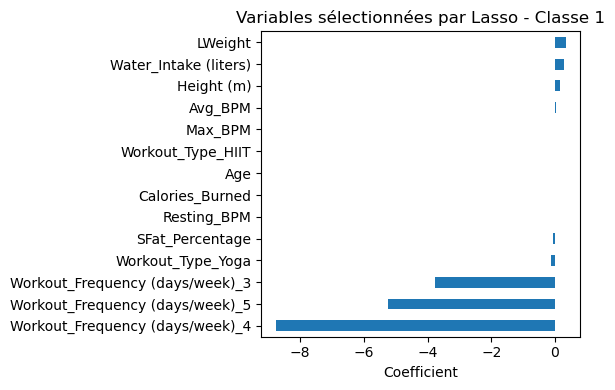

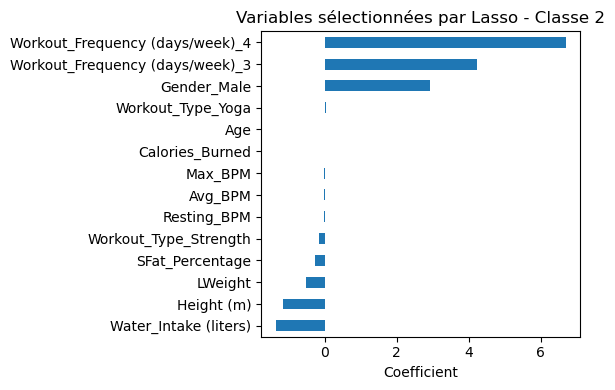

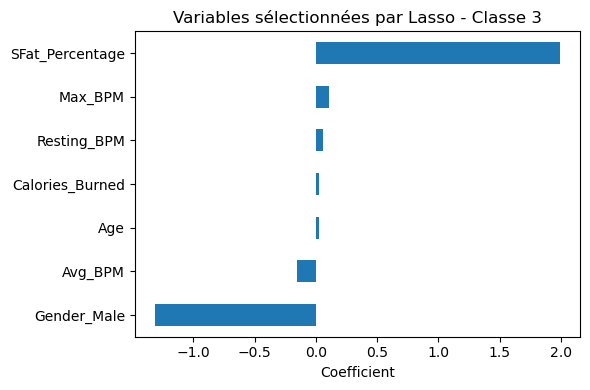

In [233]:
for i in range(3):
    # Créer une série pandas avec les noms de variables
    coefs = pd.Series(model_lasso.coef_[i], index=X_train_exp_level_dummies.columns)
    
    # Filtrer les coefficients non nuls
    coefs = coefs[coefs != 0].sort_values()
    
    # Affichage
    coefs.plot(kind='barh', figsize=(6, 4))
    plt.title(f"Variables sélectionnées par Lasso - Classe {i+1}")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

Ces coefficients permettent d’interpréter l’influence des variables explicatives sur la probabilité d’appartenance à chaque niveau.

Niveau d’expérience 1 :
Plusieurs coefficients sont très proches de zéro ou nuls, les variables assocées ont peu de poids explicatif.
Les coefficients associés aux variables "entraînement 3, 4 ou 5 fois/semaine" sont faibles voire négatifs. Ainsi, un individu qui s’entraîne fréquemment a une probabilité plus faible d’être de niveau 1, ce qui est cohérent.

Niveau d’expérience 2 :
Le modèle attribue des poids négatifs importants à certaines variables (ex. : entraînement hebdomadaire régulier, masse grasse élevée).
Le coefficient associé à une catégorie d’âge ou de masse grasse semble positif, ce qui peut indiquer un profil spécifique.

Niveau d’expérience 3 :
Le coefficient le plus marqué est pour une variable liée au pourcentage de masse grasse (~1.91).
Plus le pourcentage de gras est élevé, plus la probabilité d’être niveau 3 augmente.

Cette methode à supprimé moins de variables que l'équivalent en R. (vérif si meme pénalisation: L1)

Variables sélectionnées et triées (moyenne des coefficients) :
SFat_Percentage                    0.549723
Gender_Male                        0.538784
Workout_Frequency (days/week)_3    0.156145
Max_BPM                            0.034360
Resting_BPM                        0.011747
Age                                0.006791
Calories_Burned                    0.006590
Workout_Type_HIIT                  0.000375
Workout_Type_Yoga                 -0.023890
Avg_BPM                           -0.043906
Workout_Type_Strength             -0.055019
LWeight                           -0.068616
Height (m)                        -0.337689
Water_Intake (liters)             -0.362752
Workout_Frequency (days/week)_4   -0.694308
Workout_Frequency (days/week)_5   -1.745889
dtype: float64


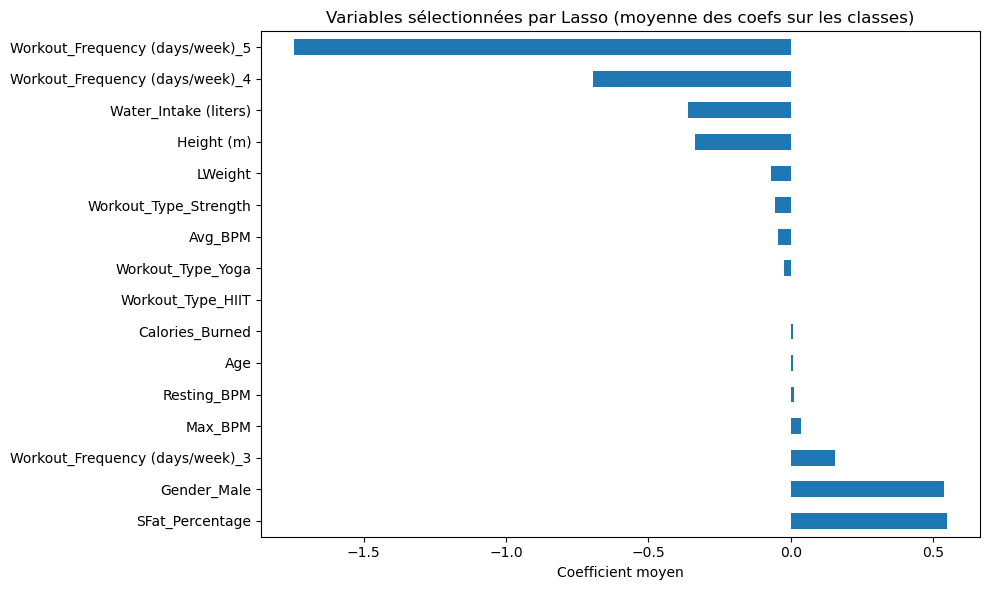

In [234]:
# Récupérer les coefficients
coefs = model_lasso.coef_  # array de shape (n_classes, n_features)

# Transformer les coefficients en DataFrame
coef_df = pd.DataFrame(coefs, columns=X_train_exp_level_dummies.columns)  # colonnes = noms des variables
coef_df.index = [f"Class_{i}" for i in range(coefs.shape[0])]  # index = classes

# Trouver les variables utilisées (au moins une fois ≠ 0 dans une classe)
coef_used = (coef_df != 0).any(axis=0)  # un mask booléen sur les colonnes
selected_coefs = coef_df.loc[:, coef_used]

# Calculer la moyenne par variable et trier
mean_coefs = selected_coefs.mean(axis=0).sort_values(ascending=False)

# 7. Afficher
print("Variables sélectionnées et triées (moyenne des coefficients) :")
print(mean_coefs)

# 8. Visualiser
mean_coefs.plot(kind='barh', figsize=(10,6))
plt.title("Variables sélectionnées par Lasso (moyenne des coefs sur les classes)")
plt.xlabel("Coefficient moyen")
plt.tight_layout()
plt.show()


Cette analyse nous permet de voir quelles variables ont le plus grand impact sur la classe cible et lesquelles sont relativement sans effet: Les variables comme SFat_Percentage et Gender_Male augmentent la probabilité d'appartenir à la classe cible, tandis que des variables comme Workout_Frequency (days/week)_5, Height, et Water_Intake la diminuent. 

In [235]:
add_model_result("Logistic Regression avec optimisation Lasso", y_test_exp_level, yChap, te-ts) 

### Analyse Discriminante linéaire  

In [236]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

ts=time.time()

method=LinearDiscriminantAnalysis()
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(X_test_exp_level_dummies,y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te=time.time()
t_total = te-ts
score 

0.9076923076923077

In [237]:

# matrice de confusion
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.907692, time running : 0 secondes
Multiclass Log Loss: 0.18770537588932418


,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,10,69,0
niveau 3,0,0,38


L'erreur de généralisation est de 10.3%, ce qui traduit une bonne capacité prédictive du modèle.

La répartition des erreurs est très proche de celle obtenue avec la régression logistique classique, avec une erreur de moins dans ce cas.
Comme précédemment observé, les individus de niveau 3 sont nettement mieux identifiés, tandis que les niveaux 1 et 2 sont plus fréquemment confondus entre eux.

In [238]:
add_model_result("ADL", y_test_exp_level, ypred, te-ts)

## K plus proches voisins 

Cas particulier d'analyse discriminante avec estimation locale des fonctions de densité conditionnelle . 

In [239]:
from sklearn.neighbors import KNeighborsClassifier
# Convert the test data to a DataFrame with the same columns as the training data
X_test_exp_level_dummies_df = pd.DataFrame(np.array(X_test_exp_level_dummies), columns=X_train_exp_level_dummies.columns)

ts=time.time()
method=KNeighborsClassifier(n_jobs=-1)
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(np.array(X_test_exp_level_dummies),y_test_exp_level)
ypred = method.predict(np.array(X_test_exp_level_dummies_df))
te=time.time()
t_total = te-ts



c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [240]:
method.predict_proba

<bound method KNeighborsClassifier.predict_proba of KNeighborsClassifier(n_jobs=-1)>

In [241]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.717949, time running : 0 secondes


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Multiclass Log Loss: 1.1846033806806355


,niveau 1,niveau 2,niveau 3
niveau 1,47,31,0
niveau 2,18,61,0
niveau 3,1,5,32


Le score obtenu est nettement inférieur à celui des autres méthodes testées précédemment, mais le temps d'exécution est très court. Le nombre de voisins utilisé par défaut est fixé à 5. Nous allons à présent chercher à optimiser ce paramètre pour améliorer les performances du modèle.

In [242]:
from sklearn.model_selection import GridSearchCV
ts=time.time()

param_grid = {'n_neighbors': list(range(1, 16))}  # Tester de 1 à 15 voisins

method=KNeighborsClassifier(n_jobs=-1)
kn= GridSearchCV(method, param_grid, cv=10, scoring='accuracy')# recherche par validation croisée
knOpt=kn.fit(np.array(X_train_exp_level_dummies), y_train_exp_level)  # Assurez-vous que X_train_np est bien un np.array

te=time.time()
t_total=te-ts

print("temps : %d secondes" %(t_total))

temps : 20 secondes


In [243]:
print("Meilleur nombre de voisins :", knOpt.best_params_['n_neighbors']) #paramètre trouvé 
print("Meilleure score en validation croisée :", knOpt.best_score_) #score généralisation vc
yChap=knOpt.predict(np.array(X_test_exp_level_dummies))
score=accuracy_score(y_test_exp_level, yChap) # score généralisation 
print("Score : %f, time running : %d secondes" %(score, t_total))
expected_loss = log_loss(y_test_exp_level, knOpt.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Meilleur nombre de voisins : 11
Meilleure score en validation croisée : 0.6954878454878455
Score : 0.728205, time running : 20 secondes
Multiclass Log Loss: 0.5397404494291402


,niveau 1,niveau 2,niveau 3
niveau 1,47,28,3
niveau 2,12,64,3
niveau 3,0,7,31


Le meilleur nombre de voisins est 11, avec un score de généralisation moyen en validation croisée de 0.695 ce qui correspond à une erreure de généralisation en validation croisée de 31%. L'erreur de généralisaion "simple" obtenue: 28% est  inférieursupperieure à celles obtenus avec les autres méthodes précédemment testées, et quasiment égale au score knn sans optimisation du nombre de voisins.

Même après optimisation du nombre de voisins, la méthode des K plus proches voisins n'est pas efficace pour classifier correctement nos données.On oberve, grace à la matrice de confusion, que le niveau 1 est particulièrement mal classé: 47 corrects, mais 28 confondus avec le niveau 2 et 3 avec le niveau 3. De plus le temps d'execution est assez long: 22s contre 5s sans optimisation de k, cette amélioration n'est pas rentable. 

In [244]:
add_model_result("KNN", y_test_exp_level, yChap, te-ts) 

## SVM lineaire 



In [245]:
from sklearn.svm import SVC
ts = time.time()
method = SVC(kernel='linear', gamma='auto', probability=True)
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
score_cv=cross_validate(method, X_train_exp_level_dummies, y_train_exp_level, cv=5, scoring='accuracy')
#mettre erreure validation croisée 
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [246]:
print("Score de généraisation : %f, time running : %d secondes" %(score, te-ts))
print("Score de généralisation par validation croisée : %f" %(score_cv['test_score'].mean()))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)
#ajouter erreur de généralisation 

Score de généraisation : 0.912821, time running : 169 secondes
Score de généralisation par validation croisée : 0.852142
Multiclass Log Loss: 0.22081447474926574


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,68,10,0
niveau 2,7,72,0
niveau 3,0,0,38


La methode SVM linéaire, avec les paramètres par défaut est très efficace, pour un temps d'execution raisonnable: l'erreure de généralisation en validation croisée est de 15%, pour 21s d'execution. 

Nous allons maintenant faire un nouveau modèle en optimisant le paramètre de régularisation C. 

In [247]:
add_model_result("SVM linéaire défault", y_test_exp_level, ypred, te-ts)

In [248]:
ts = time.time()
param=[{"C":[0.1,0.5,1,2,5,10]}]
svm= GridSearchCV(SVC(kernel='linear'),param,cv=5,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts
print("Meilleur score de généralisation en valisation croisée= %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_)) 

Meilleur score de généralisation en valisation croisée= 0.866303, Meilleur paramètre = {'C': 0.1}


In [249]:
svmOpt=SVC(kernel='linear',C=svmOpt.best_params_['C'],probability=True)
svmOpt.fit(X_train_exp_level_dummies, y_train_exp_level)
yChap = svmOpt.predict(X_test_exp_level_dummies)
score = accuracy_score(y_test_exp_level, yChap) 
print("Score de généralisation : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, svmOpt.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score de généralisation : 0.912821, time running : 92 secondes
Multiclass Log Loss: 0.22531047296441653


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,68,10,0
niveau 2,7,72,0
niveau 3,0,0,38


Les erreurs de généralisation simple et en validation croisée sont presque égales à celles obtenues sont l'optimisation du paramètre C et le temps d'execution de ce nouveau modèle est particulièrement long: 1min54. Cette amélioration n'est pas rentable par rapport au modèle non optimisé. 

In [250]:
add_model_result("SVM linéaire optimisée", y_test_exp_level, yChap, te-ts)


### SVM radiale 

In [251]:

ts = time.time()
method = SVC(kernel='rbf',gamma='auto', probability=True)
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
score_cv=cross_validate(method, X_train_exp_level_dummies, y_train_exp_level, cv=5, scoring='accuracy')
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [252]:
print("Score de généralisation : %f, time running : %d secondes" %(score, te-ts))
print("Score de généralisation par validation croisée : %f" %(score_cv['test_score'].mean()))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score de généralisation : 0.405128, time running : 2 secondes
Score de généralisation par validation croisée : 0.420306
Multiclass Log Loss: 1.0546327097809318


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,0,78,0
niveau 2,0,79,0
niveau 3,0,38,0


Le modèle semble prédire uniquement la classe "niveau 2", quelles que soient les vraies classes.Aucune observation des niveaux 1 et 3 n’est correctement classée.L'erreur de généralisation est de 50%, cette methode est inefficace pour classer nos données.

In [253]:
add_model_result("SVM radiale défault", y_test_exp_level, ypred, te-ts)

In [254]:
ts = time.time()
param=[{"C":[0.1,0.5,1,2,10],"gamma":[0.001,.01,.1,.5,1]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts
print("Meilleur score de généralisation en validation croisée = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score de généralisation en validation croisée = 0.730153, Meilleur paramètre = {'C': 1, 'gamma': 0.001}


In [255]:
svmOpt=SVC(C=1, gamma=0.001, probability=True)
svmOpt.fit(X_train_exp_level_dummies, y_train_exp_level)
yChap=svmOpt.predict(X_test_exp_level_dummies)
score = svmOpt.score(X_test_exp_level_dummies, y_test_exp_level)
print("Score de généraisation : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score de généraisation : 0.743590, time running : 9 secondes
Multiclass Log Loss: 1.0546327097809318


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,46,31,1
niveau 2,11,67,1
niveau 3,0,6,32


Ls erreurs de classification restent nombreuses et la qualité des prédictions est limitée mais l’optimisation des paramètres a permis une amélioration notable : le modèle prédit désormais des individus dans les classes 1 et 3, contrairement à la version initiale.
L’erreur de généralisation reste élevée: 25 %, mais le temps d’exécution est plus raisonnable que celui observé lors de l’optimisation des paramètres de la SVM linéaire: 17s.


Finalement c'est la svm linéaire sans optimisation des paramètres qui est la plus adapté à notre problème de classification parmis les différentes SVM testées, elle permet d'avoir une bonne prédiction avec un temps d'execution assez faible. 

In [256]:
add_model_result("SVM radiale optimisée", y_test_exp_level, yChap, te-ts)

### Conclusion partie 1 classification

Le tableau suivant présente un résumé des performance de chaque methode testée. 

In [257]:
pd.DataFrame(results).sort_values(by="Score de généralisation", ascending=False)


,Modèle,Score de généralisation,Durée (s)
4,SVM linéaire défault,0.913,169.03
5,SVM linéaire optimisée,0.913,92.62
2,ADL,0.908,0.02
0,Logistic Regression,0.903,0.09
1,Logistic Regression avec optimisation Lasso,0.903,2.67
7,SVM radiale optimisée,0.744,9.90
3,KNN,0.728,20.93
6,SVM radiale défault,0.405,2.40


Parmi tous les modèles testés, l’analyse discriminante linéaire (ADL) offre le meilleur compromis entre précision et temps d’exécution. Elle est presque aussi performante que les meilleurs modèles, tout en étant extrêmement rapide. C’est donc un très bon choix si l’on souhaite obtenir des résultats fiables en un minimum de temps.

Si l’on cherche avant tout la meilleure précision possible et que le temps de calcul n’est pas un problème (environ 20 secondes), alors le SVM linéaire avec les paramètres par défaut est la meilleure option: on gagne 0.005 sur le score de généralisation contre 23 segondes d'execution e plus. 

En revanche, les modèles SVM avec noyau radial (RBF) et K plus proches voisins (KNN) ne sont pas adaptés à ce jeu de données. Ils donnent des résultats moins précis que les autres méthodes, voir indépendant de l'individu :la SVM radiale prédit des individus uniquement dans le second niveau d'expérience. 

Comparaison avec R: dans la regression logistique optimisé par Lasso, plus de variables sont supprimés qu'en R. 